# Conditional Average Treatment Effects (CATE) with DoWhy and EconML

This is an experimental feature where we use [EconML](https://github.com/microsoft/econml) methods from DoWhy. Using EconML allows CATE estimation using different methods. 

All four steps of causal inference in DoWhy remain the same: model, identify, estimate, and refute. The key difference is that we now call econml methods in the estimation step. There is also a simpler example using linear regression to understand the intuition behind CATE estimators. 

All datasets are generated using linear structural equations.



In [1]:
import numpy as np
import pandas as pd
import logging

import dowhy
from dowhy import CausalModel
import dowhy.datasets

import econml
import warnings
warnings.filterwarnings('ignore')

BETA = 10

In [2]:
data = dowhy.datasets.linear_dataset(BETA, num_common_causes=4, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=2,
                                     num_treatments=1,
                                    treatment_is_binary=False,
                                    num_discrete_common_causes=2,
                                    num_discrete_effect_modifiers=0,
                                    one_hot_encode=False)
df=data['df']
print(df.head())
print("True causal estimate is", data["ate"])

         X0        X1   Z0        Z1        W0        W1 W2 W3         v0  \
0 -0.504101  0.962973  1.0  0.315426  0.689546 -2.032491  3  3  26.450136   
1 -0.722767 -1.038839  0.0  0.451861 -1.006602  1.211161  3  3  18.340228   
2  0.941747  0.982907  1.0  0.043433  0.827905  0.130319  3  0  22.551607   
3 -0.518826  0.279882  1.0  0.703792 -2.170269  1.222133  2  2  24.344861   
4  1.557961 -0.323847  1.0  0.671529 -2.630031 -0.166779  1  2  18.958443   

            y  
0  288.831485  
1   81.064000  
2  399.435222  
3  214.454149  
4  308.915396  
True causal estimate is 13.407186604307467


In [3]:
model = CausalModel(data=data["df"], 
                    treatment=data["treatment_name"], outcome=data["outcome_name"], 
                    graph=data["gml_graph"])

INFO:dowhy.causal_model:Model to find the causal effect of treatment ['v0'] on outcome ['y']


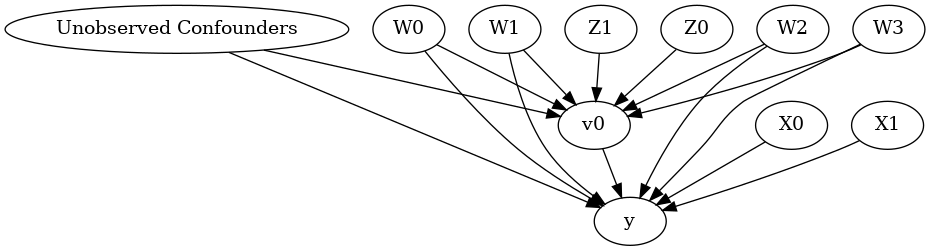

In [4]:
model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

In [5]:
identified_estimand= model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:['Z1', 'Z0']
INFO:dowhy.causal_identifier:Frontdoor variables for treatment and outcome:[]


Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor1 (Default)
Estimand expression:
  d                                    
─────(Expectation(y|W0,W1,W3,X1,W2,X0))
d[v₀]                                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W1,W3,X1,W2,X0,U) = P(y|v0,W0,W1,W3,X1,W2,X0)

### Estimand : 2
Estimand name: backdoor2
Estimand expression:
  d                                 
─────(Expectation(y|W0,W1,W3,X1,W2))
d[v₀]                               
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W1,W3,X1,W2,U) = P(y|v0,W0,W1,W3,X1,W2)

### Estimand : 3
Estimand name: backdoor3
Estimand expression:
  d                                 
─────(Expectation(y|W0,W1,W3,W2,X0))
d[v₀]                               
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W1,W3,W2,X0,U) = P(y|v0,W0,W1,W3,W2,X0)

### Estimand : 4
Estimand name: backdoor4
Estimand expression:
  d        

## Linear Model 
First, let us build some intuition using a linear model for estimating CATE. The effect modifiers (that lead to a heterogeneous treatment effect) can be modeled as interaction terms with the treatment. Thus, their value modulates the effect of treatment. 

Below the estimated effect of changing treatment from 0 to 1. 

In [6]:
linear_estimate = model.estimate_effect(identified_estimand, 
                                        method_name="backdoor.linear_regression",
                                       control_value=0,
                                       treatment_value=1)
print(linear_estimate) 

INFO:dowhy.causal_estimator:b: y~v0+W0+W1+W3+X1+W2+X0+v0*X1+v0*X0
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

## Realized estimand
b: y~v0+W0+W1+W3+X1+W2+X0+v0*X1+v0*X0
Target units: ate

## Estimate
Mean value: 13.407192015379287
### Conditional Estimates
__categorical__X1  __categorical__X0
(-4.035, -1.132]   (-2.529, 0.0771]      3.037913
                   (0.0771, 0.682]       6.679129
                   (0.682, 1.187]        9.361316
                   (1.187, 1.782]       11.676135
                   (1.782, 4.662]       15.723627
(-1.132, -0.54]    (-2.529, 0.0771]      5.414616
                   (0.0771, 0.682]       9.502870
                   (0.682, 1.187]       11.841804
                   (1.187, 1.782]       14.256876
                   (1.782, 4.662]       18.184712
(-0.54, -0.0227]   (-2.529, 0.0771]      7.061339
                   (0.0771, 0.682]      10.958178
                   (0.682, 1.187]       13.492511
                   (1.187, 1.782]       15.846991
                   (1.782, 4.662] 

## EconML methods
We now move to the more advanced methods from the EconML package for estimating CATE.

First, let us look at the double machine learning estimator. Method_name corresponds to the fully qualified name of the class that we want to use. For double ML, it is "econml.dml.DMLCateEstimator". 

Target units defines the units over which the causal estimate is to be computed. This can be a lambda function filter on the original dataframe, a new Pandas dataframe, or a string corresponding to the three main kinds of target units ("ate", "att" and "atc"). Below we show an example of a lambda function. 

Method_params are passed directly to EconML. For details on allowed parameters, refer to the EconML documentation. 

In [7]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
dml_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DML",
                                     control_value = 0,
                                     treatment_value = 1,
                                 target_units = lambda df: df["X0"]>1,  # condition used for CATE
                                 confidence_intervals=False,
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=False)},
                                               "fit_params":{}})
print(dml_estimate)

INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~v0+W0+W1+W3+X1+W2+X0 | X1,X0


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

## Realized estimand
b: y~v0+W0+W1+W3+X1+W2+X0 | X1,X0
Target units: Data subset defined by a function

## Estimate
Mean value: 17.197494868852377
Effect estimates: [16.0910598  14.14293255 13.09601451 ...  7.20839431 14.33411557
 14.8303657 ]



In [8]:
print("True causal estimate is", data["ate"])

True causal estimate is 13.407186604307467


In [9]:
dml_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DML",
                                     control_value = 0,
                                     treatment_value = 1,
                                 target_units = 1,  # condition used for CATE
                                 confidence_intervals=False,
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{}})
print(dml_estimate)

INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~v0+W0+W1+W3+X1+W2+X0 | X1,X0


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

## Realized estimand
b: y~v0+W0+W1+W3+X1+W2+X0 | X1,X0
Target units: 

## Estimate
Mean value: 13.313645469650183
Effect estimates: [10.49748055  3.6845522  17.05652063 ...  0.68500175  9.12004333
 14.73724939]



### CATE Object and Confidence Intervals
EconML provides its own methods to compute confidence intervals. Using BootstrapInference in the example below. 

In [10]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
from econml.inference import BootstrapInference
dml_estimate = model.estimate_effect(identified_estimand, 
                                     method_name="backdoor.econml.dml.DML",
                                     target_units = "ate",
                                     confidence_intervals=True,
                                     method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final": LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{
                                                               'inference': BootstrapInference(n_bootstrap_samples=100, n_jobs=-1),
                                                            }
                                              })
print(dml_estimate)

INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~v0+W0+W1+W3+X1+W2+X0 | X1,X0
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   30.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.2min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

## Realized estimand
b: y~v0+W0+W1+W3+X1+W2+X0 | X1,X0
Target units: ate

## Estimate
Mean value: 13.311914342959065
Effect estimates: [10.59070433  3.59638372 17.16822609 ...  0.54318894  9.03881794
 14.63167683]
95.0% confidence interval: (array([ 1.05545805e+01,  3.22946021e+00,  1.73281093e+01, ...,
       -6.49482631e-03,  8.89147258e+00,  1.45440938e+01]), array([10.9751903 ,  3.63012903, 17.69116243, ...,  0.51123116,
        9.11516389, 14.93539112]))



[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished


### Can provide a new inputs as target units and estimate CATE on them.

In [11]:
test_cols= data['effect_modifier_names'] # only need effect modifiers' values
test_arr = [np.random.uniform(0,1, 10) for _ in range(len(test_cols))] # all variables are sampled uniformly, sample of 10
test_df = pd.DataFrame(np.array(test_arr).transpose(), columns=test_cols)
dml_estimate = model.estimate_effect(identified_estimand, 
                                     method_name="backdoor.econml.dml.DML",
                                     target_units = test_df,
                                     confidence_intervals=False,
                                     method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{}
                                              })
print(dml_estimate.cate_estimates)

INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~v0+W0+W1+W3+X1+W2+X0 | X1,X0


[16.53054822 12.46781996 14.48135191 12.50761403 15.52006853 13.05301137
 15.40088834 13.29661592 14.66814695 14.91607035]


### Can also retrieve the raw EconML estimator object for any further operations

In [12]:
print(dml_estimate._estimator_object)

## Works with any EconML method
In addition to double machine learning, below we example analyses using orthogonal forests, DRLearner (bug to fix), and neural network-based instrumental variables. 

### Binary treatment, Binary outcome

In [13]:
data_binary = dowhy.datasets.linear_dataset(BETA, num_common_causes=4, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=2,
                                    treatment_is_binary=True, outcome_is_binary=True)
# convert boolean values to {0,1} numeric
data_binary['df'].v0 = data_binary['df'].v0.astype(int)
data_binary['df'].y = data_binary['df'].y.astype(int)
print(data_binary['df'])

model_binary = CausalModel(data=data_binary["df"], 
                    treatment=data_binary["treatment_name"], outcome=data_binary["outcome_name"], 
                    graph=data_binary["gml_graph"])
identified_estimand_binary = model_binary.identify_effect(proceed_when_unidentifiable=True)

INFO:dowhy.causal_model:Model to find the causal effect of treatment ['v0'] on outcome ['y']
INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:['Z1', 'Z0']
INFO:dowhy.causal_identifier:Frontdoor variables for treatment and outcome:[]


            X0        X1   Z0        Z1        W0        W1        W2  \
0    -0.042086 -0.807431  1.0  0.953650  0.945790 -0.200649 -2.918216   
1     1.620087  0.429226  0.0  0.928747  0.188609 -1.610478 -0.057430   
2    -1.575390 -1.409067  0.0  0.265052  0.469664  0.948116 -0.294454   
3    -0.892651  1.103229  1.0  0.170467 -0.387164 -0.300364  0.177878   
4    -0.127758  1.248801  1.0  0.076344  0.856909  0.241288  0.601427   
...        ...       ...  ...       ...       ...       ...       ...   
9995 -1.291579 -0.892028  0.0  0.901877 -0.660676 -0.943996  1.954166   
9996 -0.961398  0.736610  0.0  0.012024 -0.188996 -1.983398 -0.331466   
9997 -0.300505  0.542755  1.0  0.907418 -0.552676  0.275340 -3.810632   
9998  1.358552  1.040599  1.0  0.877140 -0.253638 -0.281386 -0.649833   
9999  0.167791 -0.315035  0.0  0.128057 -1.507981  0.181633  0.093358   

            W3  v0  y  
0     0.335050   1  1  
1     0.583046   1  1  
2    -0.238790   1  1  
3     0.631813   1  1  
4  

#### Using DRLearner estimator

In [14]:
from sklearn.linear_model import LogisticRegressionCV
#todo needs binary y
drlearner_estimate = model_binary.estimate_effect(identified_estimand_binary, 
                                method_name="backdoor.econml.drlearner.LinearDRLearner",
                                confidence_intervals=False,
                                method_params={"init_params":{
                                                    'model_propensity': LogisticRegressionCV(cv=3, solver='lbfgs', multi_class='auto')
                                                    },
                                               "fit_params":{}
                                              })
print(drlearner_estimate)
print("True causal estimate is", data_binary["ate"])

INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~v0+W0+W1+W3+X1+W2+X0 | X1,X0


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

## Realized estimand
b: y~v0+W0+W1+W3+X1+W2+X0 | X1,X0
Target units: ate

## Estimate
Mean value: 0.5487309380359678
Effect estimates: [0.54844626 0.54665087 0.55012232 ... 0.54878221 0.54696306 0.54823195]

True causal estimate is 0.3483


### Instrumental Variable Method

In [15]:
import keras
from econml.deepiv import DeepIVEstimator
dims_zx = len(model._instruments)+len(model._effect_modifiers)
dims_tx = len(model._treatment)+len(model._effect_modifiers)
treatment_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(dims_zx,)), # sum of dims of Z and X 
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.Dropout(0.17)])                
response_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(dims_tx,)), # sum of dims of T and X
                                    keras.layers.Dropout(0.17), 
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(1)])

deepiv_estimate = model.estimate_effect(identified_estimand, 
                                        method_name="iv.econml.deepiv.DeepIV",
                                        target_units = lambda df: df["X0"]>-1, 
                                        confidence_intervals=False,
                                method_params={"init_params":{'n_components': 10, # Number of gaussians in the mixture density networks
                                                              'm': lambda z, x: treatment_model(keras.layers.concatenate([z, x])), # Treatment model,
                                                              "h": lambda t, x: response_model(keras.layers.concatenate([t, x])), # Response model
                                                              'n_samples': 1, # Number of samples used to estimate the response
                                                              'first_stage_options': {'epochs':25},
                                                              'second_stage_options': {'epochs':25}
                                                             },
                                               "fit_params":{}})
print(deepiv_estimate)

Using TensorFlow backend.
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~v0+W0+W1+W3+X1+W2+X0 | X1,X0


Epoch 1/25
10000/10000 [==============================] - 3s 282us/step - loss: 8.6817
Epoch 2/25
10000/10000 [==============================] - 2s 243us/step - loss: 2.8319
Epoch 3/25
10000/10000 [==============================] - 3s 251us/step - loss: 2.5036
Epoch 4/25
10000/10000 [==============================] - 3s 263us/step - loss: 2.4126
Epoch 5/25
10000/10000 [==============================] - 2s 225us/step - loss: 2.3842
Epoch 6/25
10000/10000 [==============================] - 2s 191us/step - loss: 2.3654
Epoch 7/25
10000/10000 [==============================] - 2s 196us/step - loss: 2.3307
Epoch 8/25
10000/10000 [==============================] - 3s 263us/step - loss: 2.3166
Epoch 9/25
10000/10000 [==============================] - 3s 276us/step - loss: 2.3076
Epoch 10/25
10000/10000 [==============================] - 2s 172us/step - loss: 2.3064
Epoch 11/25
10000/10000 [==============================] - 2s 244us/step - loss: 2.2800
Epoch 12/25
10000/10000 [================

### Metalearners

In [16]:
data_experiment = dowhy.datasets.linear_dataset(BETA, num_common_causes=5, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=5,
                                    treatment_is_binary=True, outcome_is_binary=False)
# convert boolean values to {0,1} numeric
data_experiment['df'].v0 = data_experiment['df'].v0.astype(int)
print(data_experiment['df'])
model_experiment = CausalModel(data=data_experiment["df"], 
                    treatment=data_experiment["treatment_name"], outcome=data_experiment["outcome_name"], 
                    graph=data_experiment["gml_graph"])
identified_estimand_experiment = model_experiment.identify_effect(proceed_when_unidentifiable=True)

INFO:dowhy.causal_model:Model to find the causal effect of treatment ['v0'] on outcome ['y']
INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:['Z1', 'Z0']
INFO:dowhy.causal_identifier:Frontdoor variables for treatment and outcome:[]


            X0        X1        X2        X3        X4   Z0        Z1  \
0     1.171326 -0.064640 -0.563460  1.582340  1.756091  1.0  0.580542   
1    -1.650940 -3.389096 -0.149817 -0.461226  0.219358  1.0  0.365706   
2     0.765107 -0.345213 -0.738163  1.844420  1.575668  1.0  0.283551   
3     0.647960 -1.742912 -0.199341  1.813745  1.681489  1.0  0.358249   
4     1.348120  0.746108  0.178642  0.658514 -1.781014  1.0  0.930622   
...        ...       ...       ...       ...       ...  ...       ...   
9995 -0.917608  0.028557 -0.933144  1.965266  1.261264  0.0  0.341334   
9996 -0.225002 -2.037790 -0.525940 -0.033352  1.699422  1.0  0.599149   
9997  1.824837 -0.995047 -0.367880  1.245476 -0.721379  1.0  0.602085   
9998 -0.983748 -1.956581 -1.342196  1.588319  0.285659  1.0  0.350946   
9999  0.691610 -1.951029 -0.761671  0.476826 -0.353760  1.0  0.935597   

            W0        W1        W2        W3        W4  v0          y  
0     1.201150  1.995054  2.066612  0.753675  0.198

In [17]:
from sklearn.ensemble import RandomForestRegressor
metalearner_estimate = model_experiment.estimate_effect(identified_estimand_experiment, 
                                method_name="backdoor.econml.metalearners.TLearner",
                                confidence_intervals=False,
                                method_params={"init_params":{
                                                    'models': RandomForestRegressor()
                                                    },
                                               "fit_params":{}
                                              })
print(metalearner_estimate)
print("True causal estimate is", data_experiment["ate"])

INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~v0+X2+X1+X3+X4+X0+W0+W1+W3+W2+W4


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

## Realized estimand
b: y~v0+X2+X1+X3+X4+X0+W0+W1+W3+W2+W4
Target units: ate

## Estimate
Mean value: 16.94419202330739
Effect estimates: [31.04055359  9.3105599  25.82728696 ... 11.36945968 17.92448425
 19.56080328]

True causal estimate is 11.707629086241594


## Refuting the estimate

### Random 

In [18]:
res_random=model.refute_estimate(identified_estimand, dml_estimate, method_name="random_common_cause")
print(res_random)

INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~v0+W0+W1+W3+X1+W2+X0 | X1,X0


Refute: Add a Random Common Cause
Estimated effect:14.284213557861628
New effect:14.257862257378136



### Adding an unobserved common cause variable

In [19]:
res_unobserved=model.refute_estimate(identified_estimand, dml_estimate, method_name="add_unobserved_common_cause",
                                     confounders_effect_on_treatment="linear", confounders_effect_on_outcome="linear",
                                    effect_strength_on_treatment=0.01, effect_strength_on_outcome=0.02)
print(res_unobserved)

INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~v0+W0+W1+W3+X1+W2+X0 | X1,X0


Refute: Add an Unobserved Common Cause
Estimated effect:14.284213557861628
New effect:14.296399827365647



### Replacing treatment with a random (placebo) variable

In [20]:
res_placebo=model.refute_estimate(identified_estimand, dml_estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute",
        num_simulations=10 # at least 100 is good, setting to 10 for speed 
        ) 
print(res_placebo)

INFO:dowhy.causal_refuters.placebo_treatment_refuter:Refutation over 10 simulated datasets of permute treatment
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W0+W1+W3+X1+W2+X0 | X1,X0
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W0+W1+W3+X1+W2+X0 | X1,X0
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W0+W1+W3+X1+W2+X0 | X1,X0
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W0+W1+W3+X1+W2+X0 | X1,X0
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W0+W1+W3+X1+W2+X0 | X1,X0
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W0+W1+W3+X1+W2+X0 | X1,X0
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~placebo+W0+W1+W3+X1+W2+X0 | X1,X0
INFO:dowhy.causal_es

Refute: Use a Placebo Treatment
Estimated effect:14.284213557861628
New effect:-0.031152830623866274
p value:0.3458388139200408



### Removing a random subset of the data

In [21]:
res_subset=model.refute_estimate(identified_estimand, dml_estimate,
        method_name="data_subset_refuter", subset_fraction=0.8,
        num_simulations=10)
print(res_subset)

INFO:dowhy.causal_refuters.data_subset_refuter:Refutation over 0.8 simulated datasets of size 8000.0 each
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~v0+W0+W1+W3+X1+W2+X0 | X1,X0
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~v0+W0+W1+W3+X1+W2+X0 | X1,X0
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~v0+W0+W1+W3+X1+W2+X0 | X1,X0
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~v0+W0+W1+W3+X1+W2+X0 | X1,X0
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~v0+W0+W1+W3+X1+W2+X0 | X1,X0
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~v0+W0+W1+W3+X1+W2+X0 | X1,X0
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~v0+W0+W1+W3+X1+W2+X0 | X1,X0
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO

Refute: Use a subset of data
Estimated effect:14.284213557861628
New effect:14.233661042403687
p value:0.17159774240261338



More refutation methods to come, especially specific to the CATE estimators.